In [1]:
# %%
import sys
import pickle
from pathlib import Path

import torch
import numpy as np
import scvelo as scv
from deepvelo.utils.velocity import velocity
from deepvelo.utils.util import update_dict, save_model_and_config
from deepvelo.utils.temporal import latent_time
from deepvelo import train, Constants
from sklearn.decomposition import PCA
from umap import UMAP

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params(
    "scvelo", transparent=False
)  # for beautified visualization

%load_ext autoreload
%autoreload 2

Using backend: pytorch


# Load hindbrain data and preprocess

In [2]:
adata = scv.read('deepvelo_data/h5ad_files/Hindbrain_GABA_Glio.h5ad', cache=True)
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)

Filtered out 45980 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:19) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# DeepVelo

In [3]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo",
    "data_loader": {"args": {"type": "pca, t"}},
    "loss": {"args": {"coeff_u": 1.0, "coeff_s": 0.5}},
    "trainer": {"epochs": 100, "verbosity": 0},
}
configs = update_dict(Constants.default_configs, configs)


In [4]:
# initial velocity
velocity(adata, mask_zero=False)
trainer = train(adata, configs)

computing velocities
    finished (0:00:06) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
{'name': 'DeepVelo', 'n_gpu': 1, 'arch': {'type': 'VeloGCN', 'args': {'n_genes': 2000, 'layers': [64, 64], 'dropout': 0.2, 'fc_layer': False, 'pred_unspliced': False}}, 'data_loader': {'type': 'VeloDataLoader', 'args': {'basis': 'pca', 'batch_size': 13501, 'shuffle': False, 'validation_split': 0.0, 'num_workers': 2, 'type': 'pca, t', 'topC': 30, 'topG': 20}}, 'online_test': 'velo_mat_E10-12.npz', 'optimizer': {'type': 'Adam', 'args': {'lr': 0.001, 'weight_decay': 0, 'amsgrad': True}}, 'loss': {'type': 'mle_plus_direction', 'args': {'pearson_scale': 18.0, 'coeff_u': 1.0, 'coeff_s': 0.5}}, 'constraint_loss': False, 'mask_zeros': False, 'metrics': ['mse'], 'lr_scheduler': {'type': 'StepLR', 'args': {'step_size': 1, 'gamma': 0.97}}, 'trainer': {'epochs': 100, 'save_dir': 'saved/', 'save_period': 1000, 'verbosity': 0, 'monitor': 'min mse', 'guided_epochs': 0, 'earl

INFO:train:VeloGCN(
  (layers): ModuleList(
    (0): GraphConv(in=4000, out=64, normalization=both, activation=<function relu at 0x7f789774b268>)
    (1): GraphConv(in=64, out=64, normalization=both, activation=<function relu at 0x7f789774b268>)
    (2): GraphConv(in=64, out=4000, normalization=both, activation=None)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)
Trainable parameters: 520224


velo data shape: torch.Size([13501, 2000])


velo_mat shape: (13501, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


In [5]:
scv.tl.velocity_graph(adata, n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/13501 [00:00<?, ?cells/s]

    finished (0:00:55) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:03) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


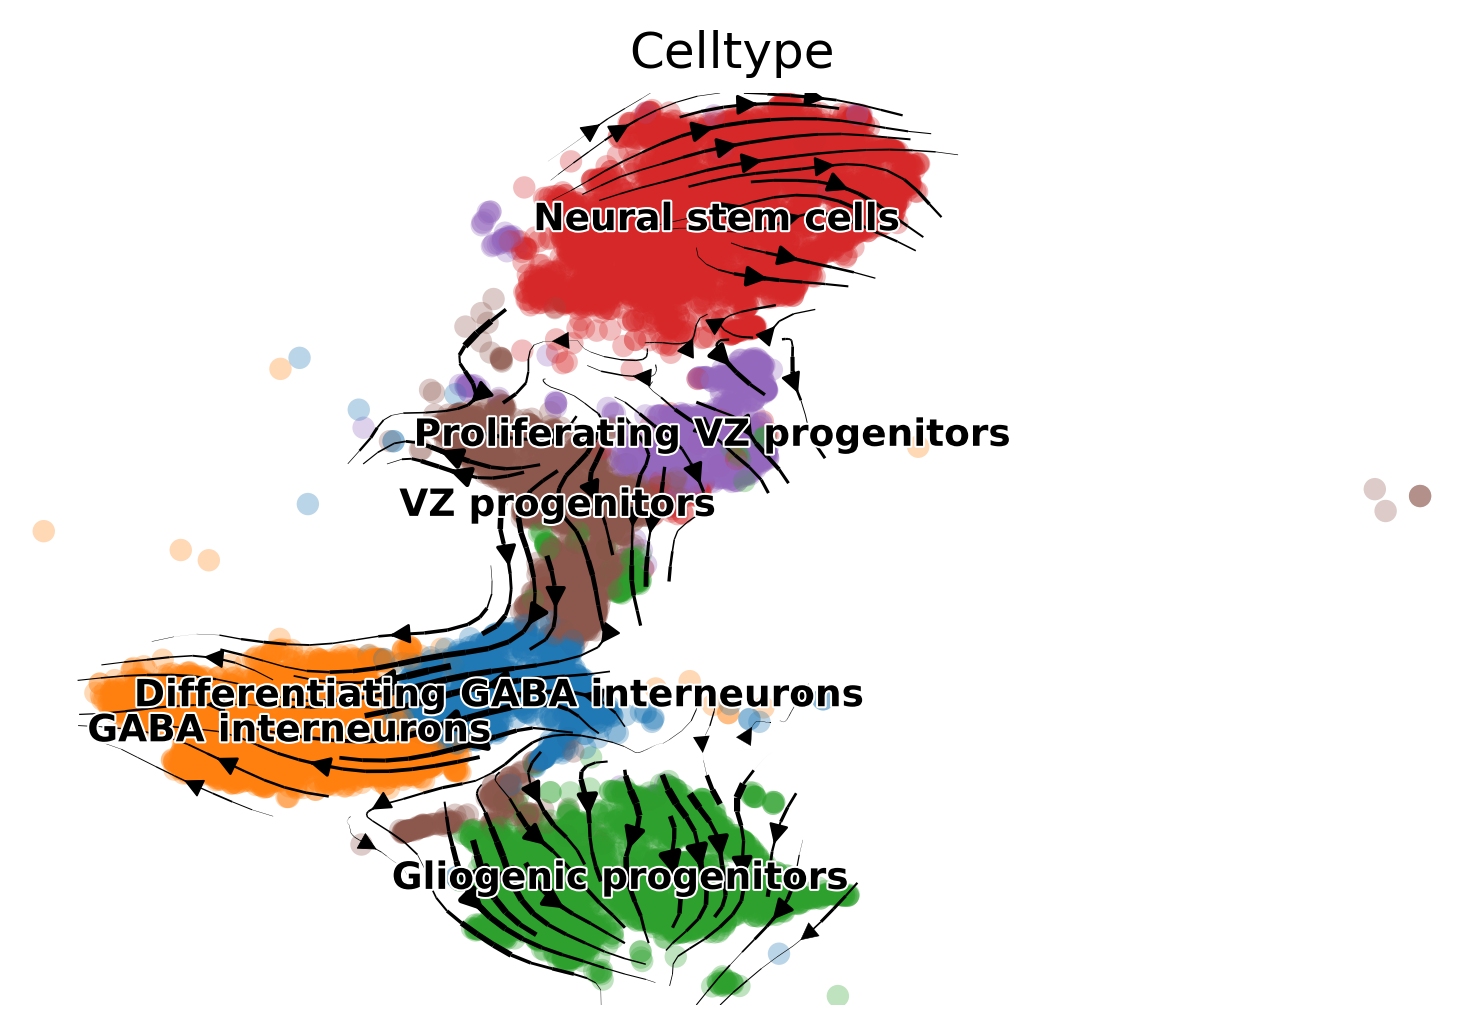

In [6]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="Celltype",
    legend_fontsize=9,
    dpi=150,
)

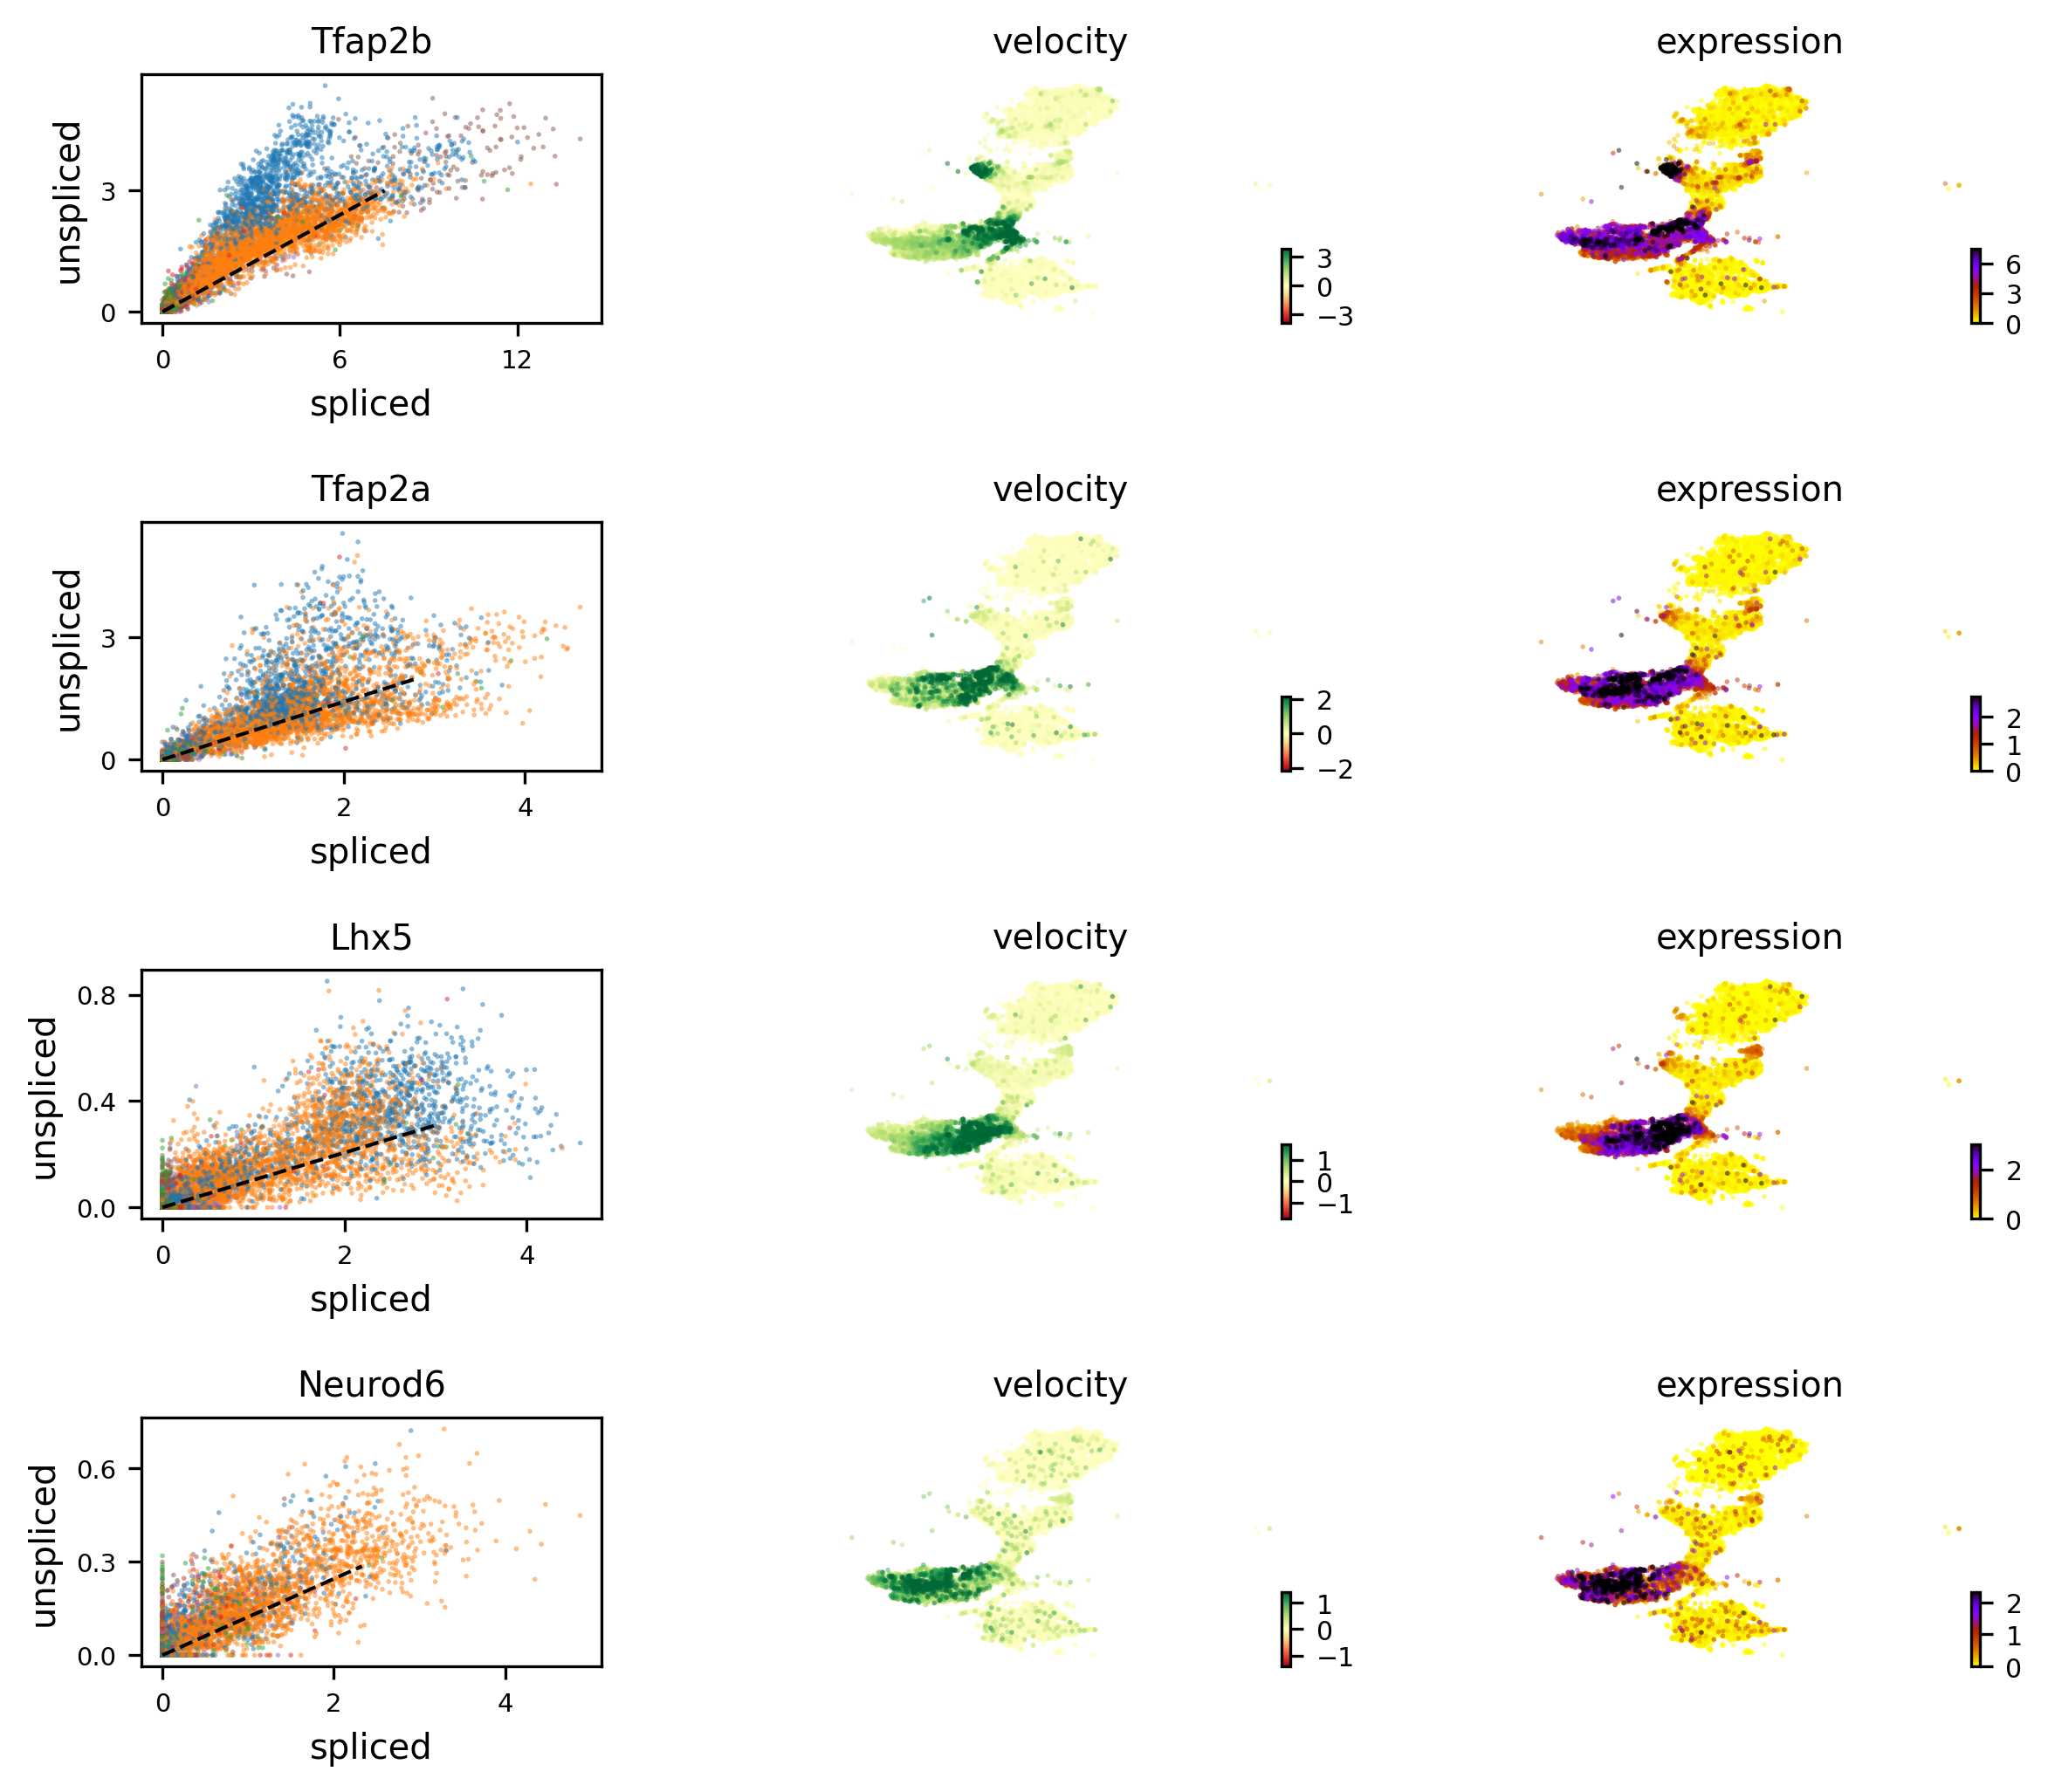

In [7]:
scv.pl.velocity(
    adata,
    var_names=["Tfap2b", "Tfap2a", "Lhx5", "Neurod6"],
    basis="tsne",
    color="Celltype",
    dpi=150,
)


computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


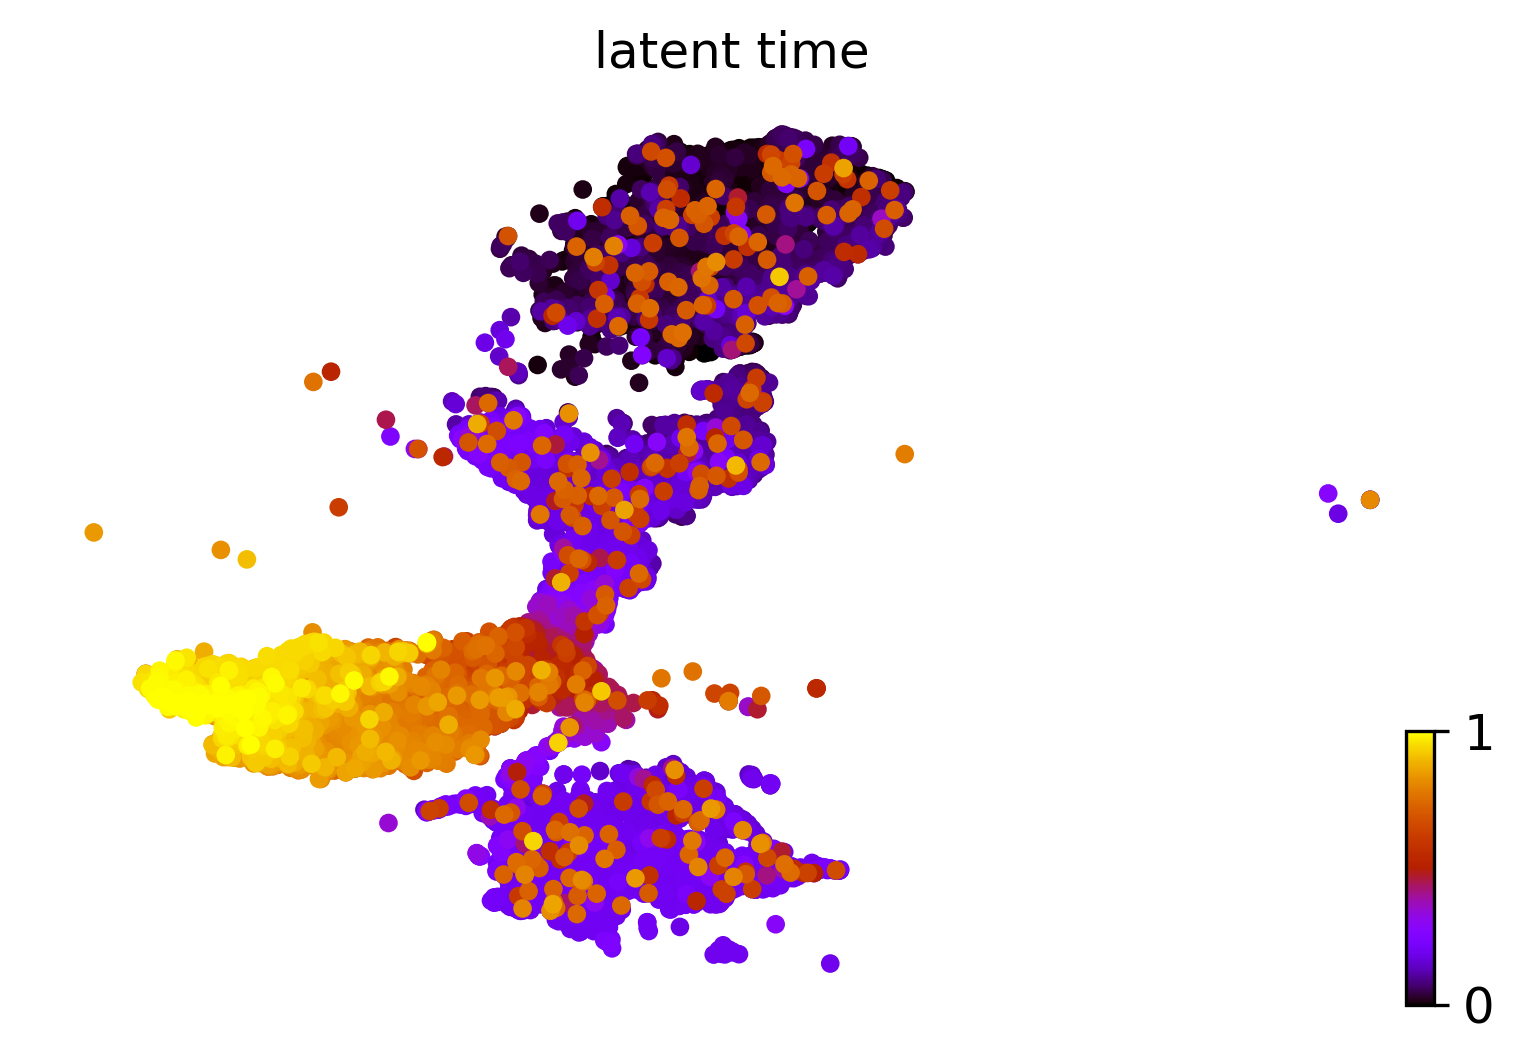

In [8]:
# pseudo-time plot
latent_time(adata)
scv.pl.scatter(
    adata,
    color='latent_time',
    color_map='gnuplot',
    size=80,
    dpi=150,
)

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


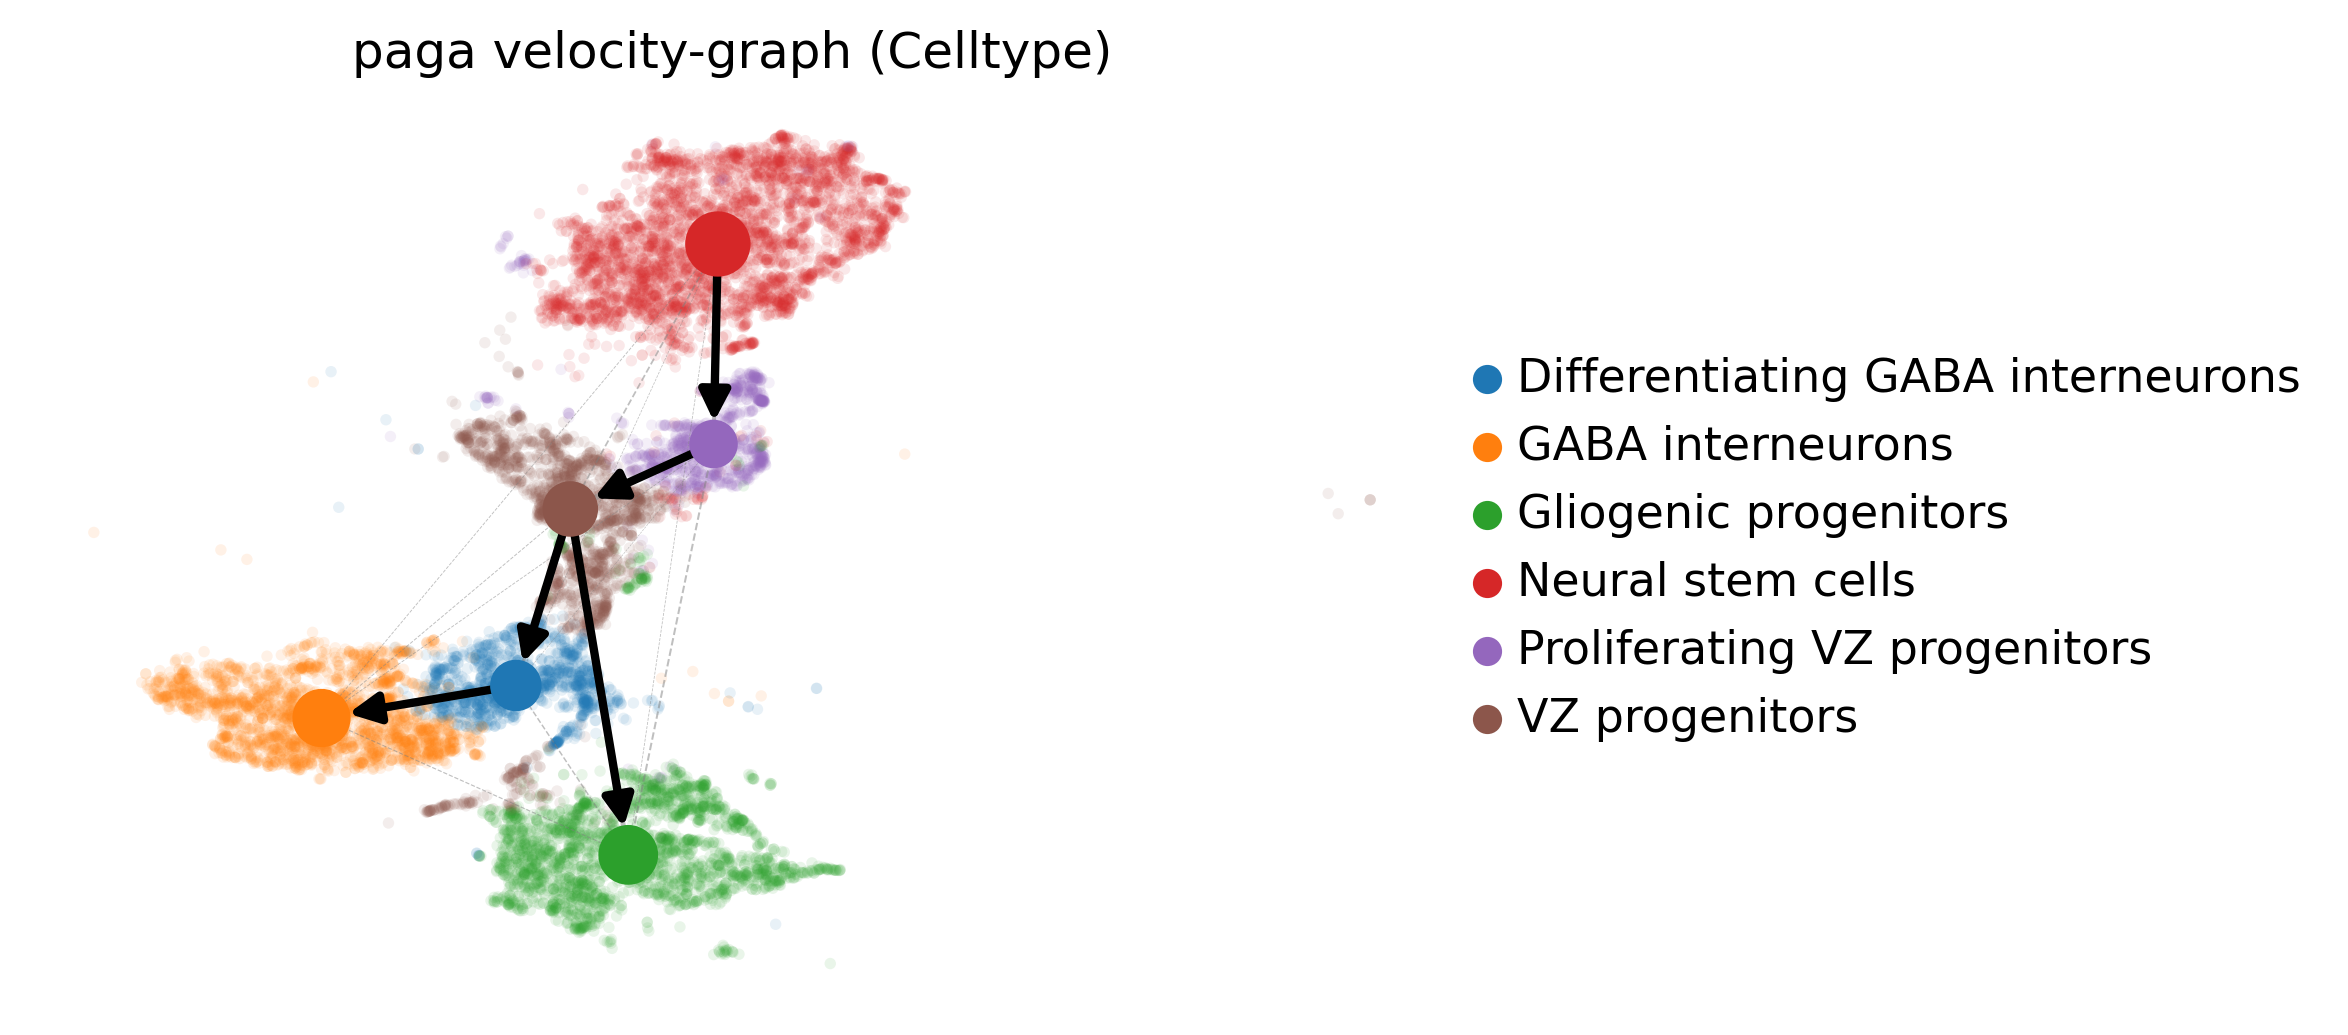

In [9]:
# trajectory inference
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']
scv.tl.paga(adata, groups="Celltype")
scv.pl.paga(
    adata,
    basis="tsne",
    size=30,
    alpha=0.1,
    min_edge_width=2,
    node_size_scale=1,
    dpi=150,
)


In [10]:
deepvelo_adata = adata.copy()
save_dir = Path("saved/hindbrain")
save_dir.mkdir(exist_ok=True, parents=True)
deepvelo_adata.write(save_dir / "Hindbrain_GABA_Glio[DeepVelo].h5ad")
# save pytorch model and configs
save_model_and_config(trainer.model, configs, save_dir)

# scVelo (dynamical)

In [11]:
adata = scv.read('../data/Hindbrain_GABA_Glio.h5ad', cache=True)
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)

Filtered out 45980 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [12]:
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode="dynamical")


recovering dynamics (using 8/8 cores)


  0%|          | 0/1325 [00:00<?, ?gene/s]

    finished (0:08:37) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:19) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [13]:
scv.tl.velocity_graph(adata, n_jobs=8)


computing velocity graph (using 8/8 cores)


  0%|          | 0/13501 [00:00<?, ?cells/s]

    finished (0:00:36) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:04) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


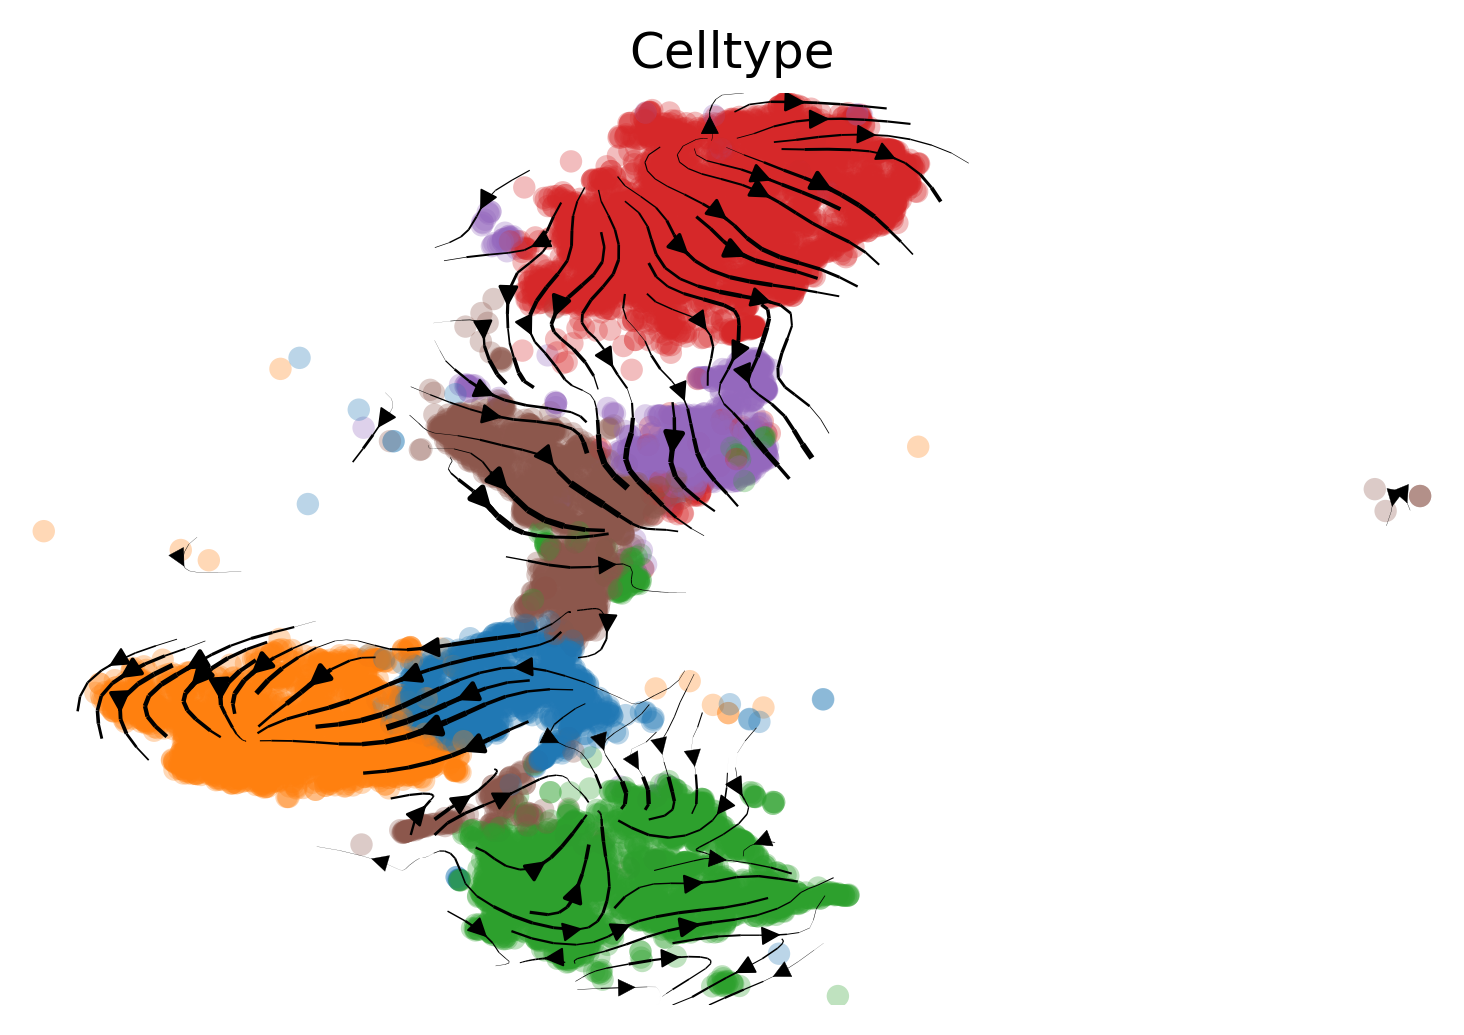

In [14]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="Celltype",
    legend_loc="none",
    legend_fontsize=9,
    dpi=150,
)

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


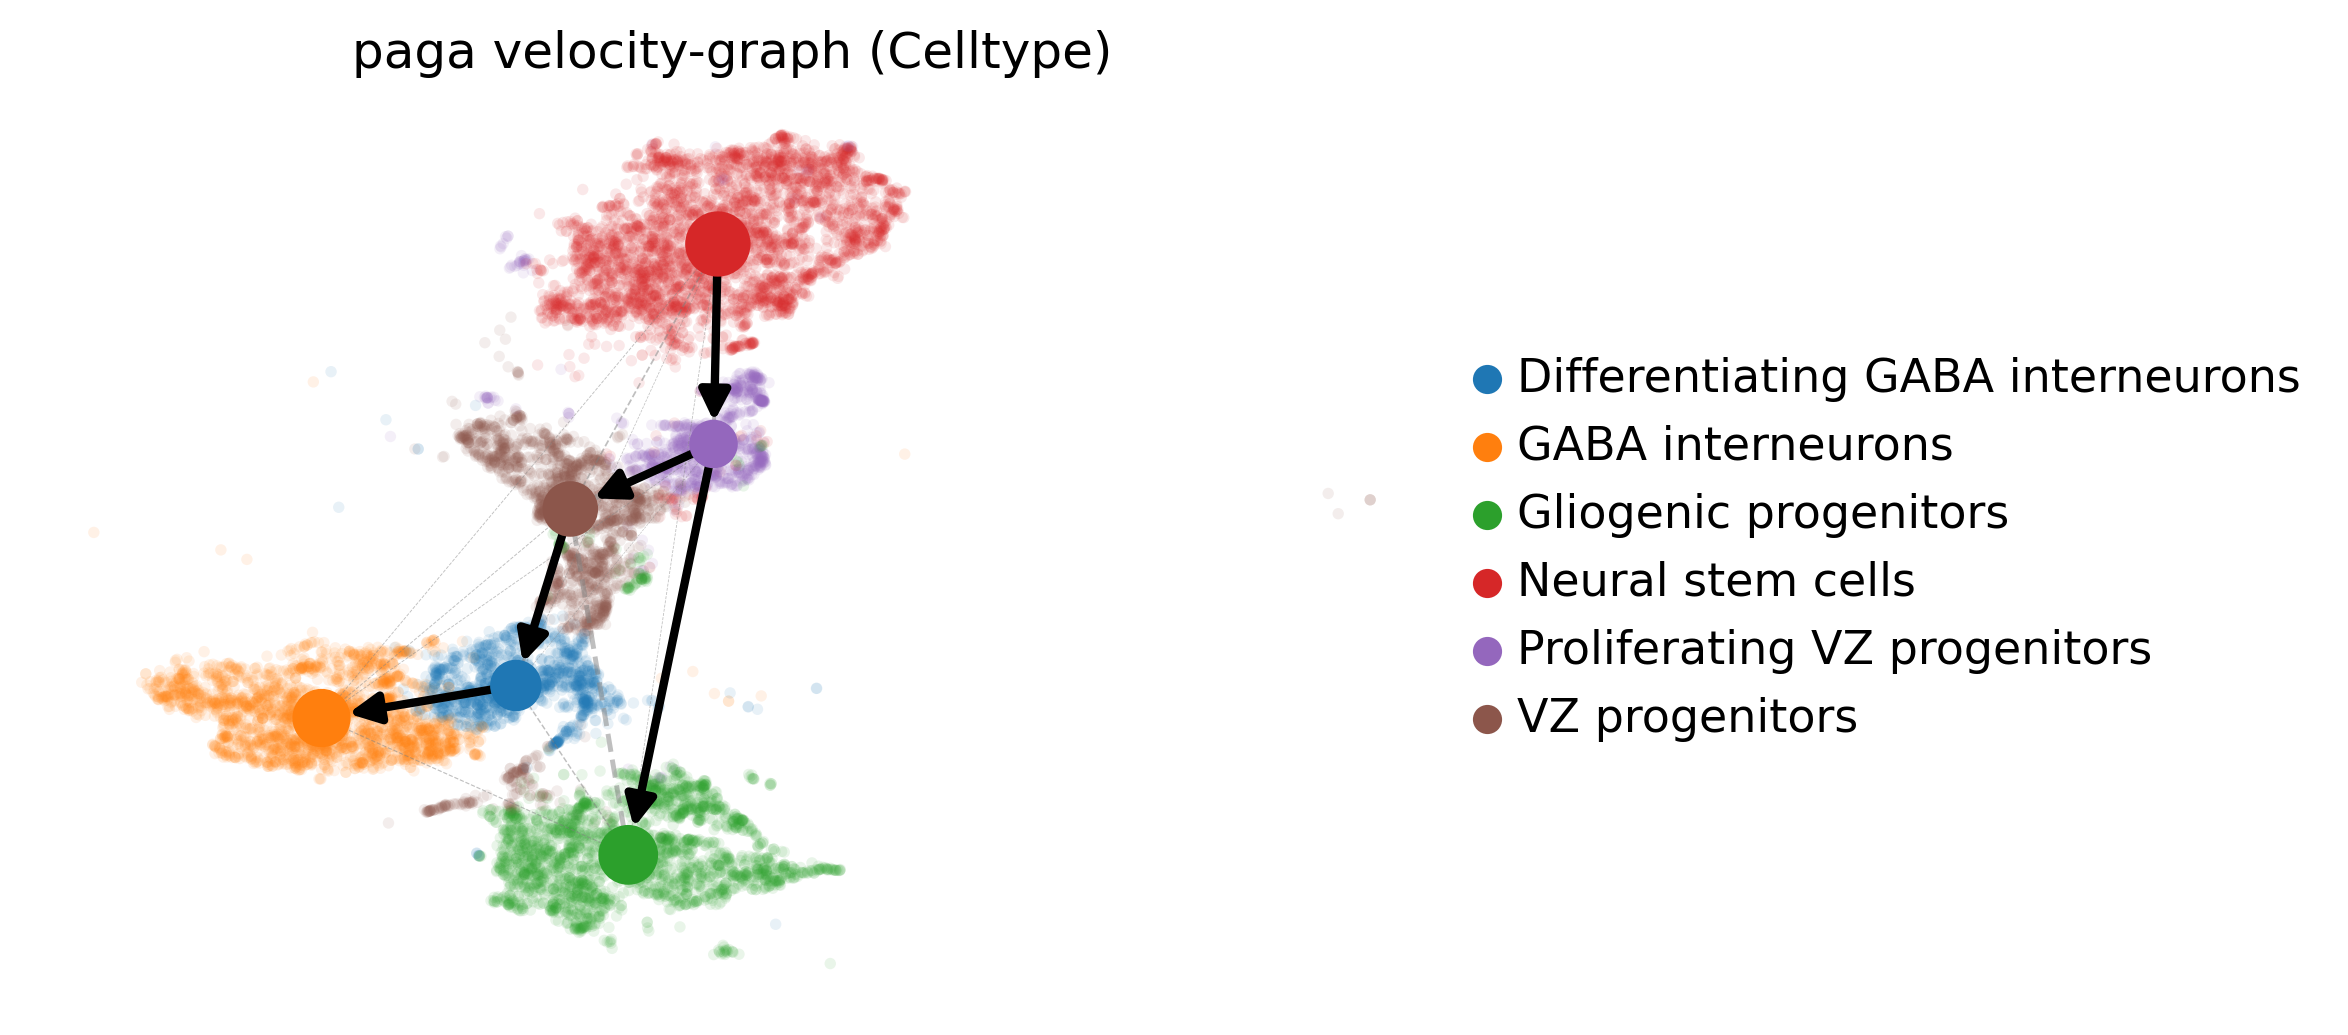

In [15]:
scv.tl.paga(adata, groups="Celltype")
scv.pl.paga(
    adata,
    basis="tsne",
    size=30,
    alpha=0.1,
    min_edge_width=2,
    node_size_scale=1,
    dpi=150,
)

In [16]:
# save adata for next steps
dynamical_adata = adata.copy()

# Compare consistency score

In [17]:
from deepvelo.utils.confidence import velocity_confidence
from deepvelo.utils.plot import statplot, compare_plot

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
DeepVelo mean score: 0.9280, std: 0.0494
Dynamical mean score: 0.8824, std: 0.1479


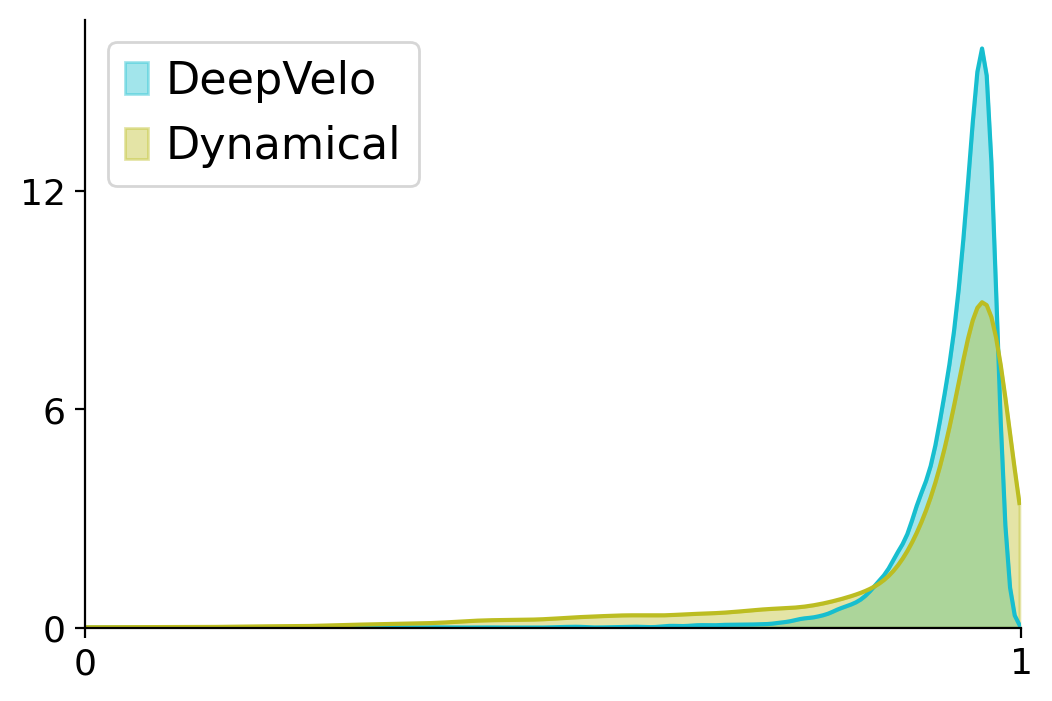

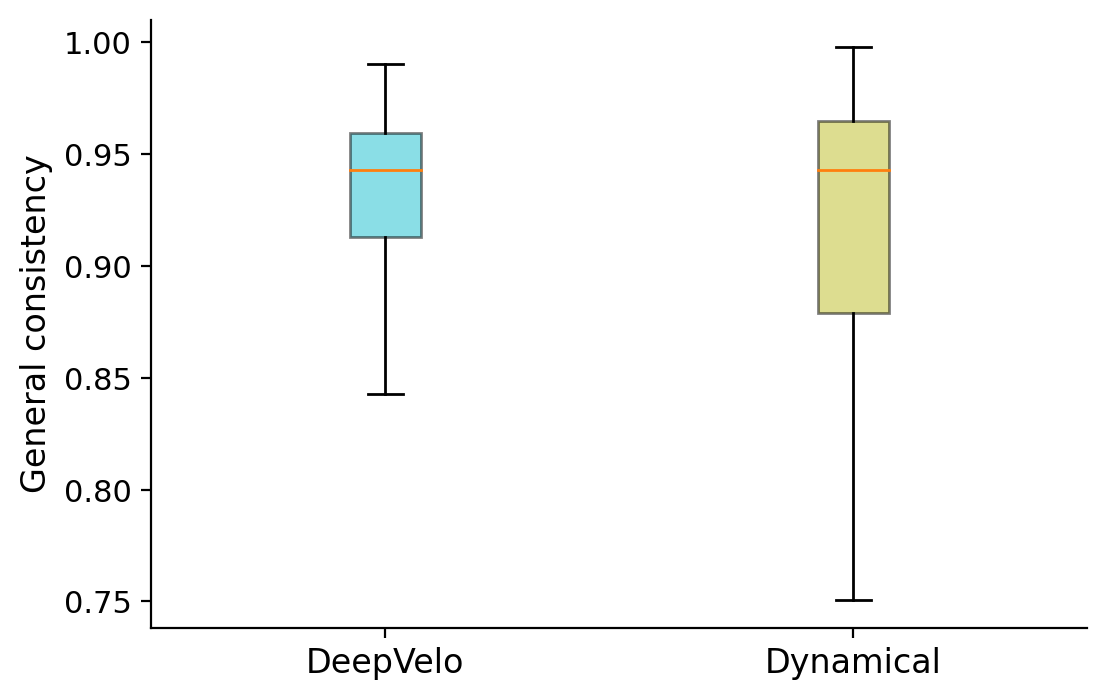

In [18]:
vkey = "velocity"
method = "cosine"
velocity_confidence(deepvelo_adata, vkey=vkey, method=method)
velocity_confidence(dynamical_adata, vkey=vkey, method=method)
compare_plot(deepvelo_adata, dynamical_adata, method=method)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
DeepVelo mean score: 0.6085, std: 0.1238
Dynamical mean score: 0.5428, std: 0.3225


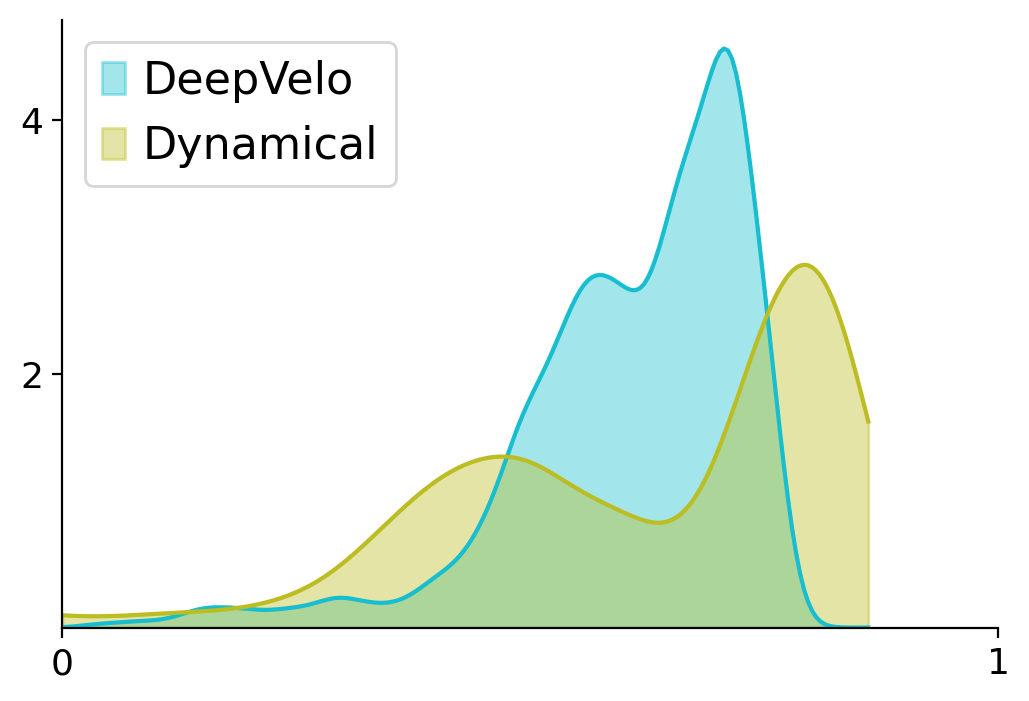

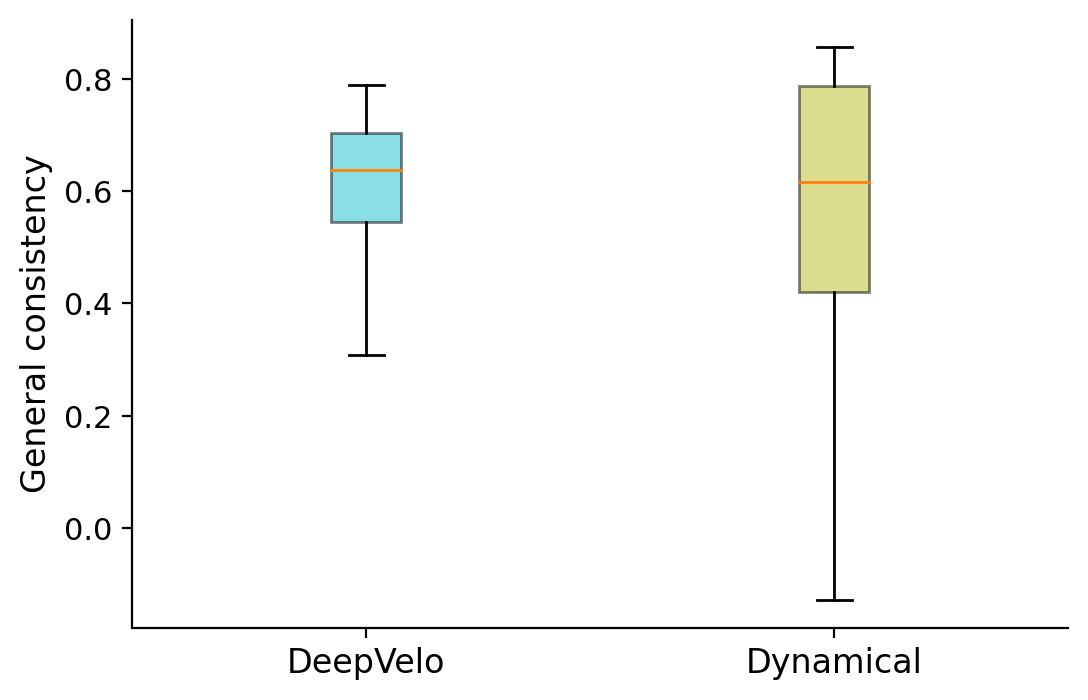

In [19]:
vkey = "velocity"
method = "cosine"
scope_key = "Celltype"
# 3. cosine similarity, compute within Celltype
velocity_confidence(deepvelo_adata, vkey=vkey, method=method, scope_key=scope_key)
velocity_confidence(dynamical_adata, vkey=vkey, method=method, scope_key=scope_key)
compare_plot(deepvelo_adata, dynamical_adata, method=method)